# Time Series - Arima PETR4

Nesse código vamos fazer uso de séries temporais para prever os preços da ação PETR4. 
Definição de Série Temporal: é uma sequência de dados ao longo do tempo, onde as observações são capturadas em espaços de tempo
regulares. A principal motivação de usar séries temporais é para entender o processo gerador de determinado dado e também para 
"desenhar" um modelo que seja capaz de monitorar e fazer previsões sobre este processo. É importante frisar que uma série 
temporal possui três componentes: Tendência, sazonalidade e resíduo. A tendência diz respeito a direção de longo prazo da 
séries, a sazonalidade são as oscilações periodicas devido a carecterística temporal da série e o resíduo são as flutuações 
irregulares e aleatórias.

In [94]:
# Importando bibliotecas (obs: datetime para pegar dados em sites)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas_datareader.data as web
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error

In [95]:
# Importando pacote Arima
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

In [96]:
# Especificando o período da série histórica
start = dt.datetime(2018,1,1)
end = dt.datetime(2020,6,30)

In [122]:
# Importando dados do yahoo finance
petr4 = web.DataReader("PETR4.SA", "yahoo", start, end)

In [123]:
# DataFrame com os preços de: Máximo, Mínimo, Abertura, Fechamento, Volume e Preço Ajustado
petr4

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,16.549999,16.190001,16.190001,16.549999,33461800.0,15.353477
2018-01-03,16.719999,16.370001,16.490000,16.700001,55940900.0,15.492632
2018-01-04,16.959999,16.620001,16.780001,16.730000,37064900.0,15.520465
2018-01-05,16.860001,16.570000,16.700001,16.830000,26958200.0,15.613236
2018-01-08,17.030001,16.709999,16.740000,17.030001,28400000.0,15.798776
...,...,...,...,...,...,...
2020-06-24,21.559999,20.709999,21.490000,21.000000,65162400.0,20.999582
2020-06-25,21.469999,20.730000,20.910000,21.469999,47263500.0,21.469574
2020-06-26,21.469999,20.780001,21.209999,20.840000,55499300.0,20.839586


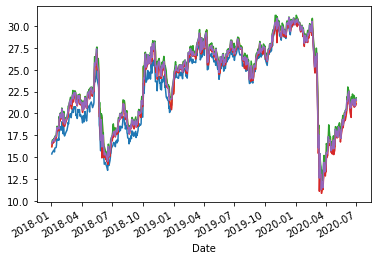

In [124]:
# Gráficos dos preços coletados
petr4["Adj Close"].plot()
petr4["Open"].plot()
petr4["High"].plot()
petr4["Low"].plot()
petr4["Close"].plot()

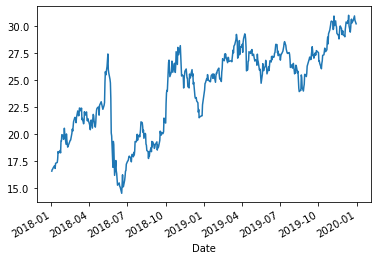

In [125]:
# Separando dados para o treino e visualizando
petr4_close = petr4["Close"]
petr4_treino = petr4_close["2018-01-01":"2020-01-01"]
petr4_treino.plot()


In [132]:
# Tipo de dados
print(petr4_treino.dtypes)

# Verificando se as datas estão lidas
petr4_treino.index

float64


DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-15',
               ...
               '2019-12-13', '2019-12-16', '2019-12-17', '2019-12-18',
               '2019-12-19', '2019-12-20', '2019-12-23', '2019-12-26',
               '2019-12-27', '2019-12-30'],
              dtype='datetime64[ns]', name='Date', length=492, freq=None)

In [127]:
# Existe NaNs nos dados?
print(petr4_treino.isnull().values.any().sum())

0


In [128]:
# Conhecendo nossa base inteira - estatística descritiva
petr4_close.describe()

count    614.000000
mean      23.665619
std        4.584605
min       11.290000
25%       19.937500
50%       25.155000
75%       27.335000
max       30.969999
Name: Close, dtype: float64

In [129]:
# Conhecendo os dados de treino - estatística descritiva
petr4_treino.describe()

count    492.000000
mean      24.140793
std        4.031577
min       14.500000
25%       20.732500
50%       25.459999
75%       27.252500
max       30.969999
Name: Close, dtype: float64

A princípio as estatísticas descritivas dos dois conjuntos (treino e série completa) são bem parecidas. Essa investigação é necessária para dar início ao processo de verificar se a série é estacionária, como preoconiza a teoria.
Uma série estacionária é um processo aleatório com média e variância constante. Saber se uma série é estacionária ou não é importante para calibrar o modelo que estamos "desenhando" para fazer previsões. A seguir vamos realizar teste de estacionariedade, Augmented Dicky Fuller.

In [133]:
# Teste de Estacionariedade para toda a série
def teste_estacionariedade(serie):
    # Estatisticas de rolamento (Rolling Statistics)
    rol_mean = serie.rolling(window=12).mean()
    rol_std = serie.rolling(window=12).std()
    plt.plot(serie, color='black',label='Original')
    plt.plot(rol_mean, color='red', label='Média')
    plt.plot(rol_std, color='blue', label='Desvio Padrão')
    plt.xlabel('Data')
    plt.ylabel("R$")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    return [rol_mean.index,serie,rol_mean,rol_std]

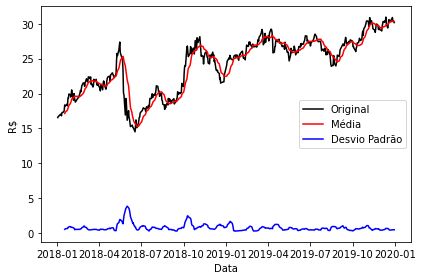

In [134]:
indice, serie, media_serie,std_serie = teste_estacionariedade(petr4_treino)

In [135]:
# Comprovando com Teste de ADF adfuller
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(petr4_treino, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)


Results of Dickey-Fuller Test:
Test Statistic                  -2.005598
p-value                          0.284124
#Lags Used                       6.000000
Number of Observations Used    485.000000
Critical Value (1%)             -3.443905
Critical Value (5%)             -2.867518
Critical Value (10%)            -2.569954
dtype: float64


O teste de ADF pressupõe que a série é não-estacionária. H0: Não estacionária H1: Estacionária. 
Caso o p-valor maior que 0.05, então a série é não estacionária. Como podemos perceber, a petr4_treino é não estacionário.
Os próximos passos são realizados para tornar a série estacionária. Algumas técnincas a exemplo 
da diferenciação e transformação em log são úteis para tornar os dados estacionários.

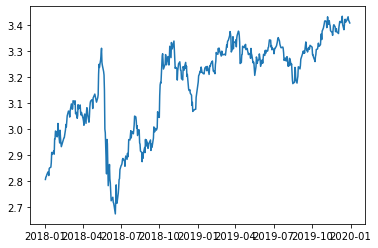

In [136]:
# A primeira coisa a se fazer é saber se o log é estacionário ( o gráfico indica que a série ainda não é estacionária)
ts_log = np.log(petr4_treino)
plt.plot(ts_log)

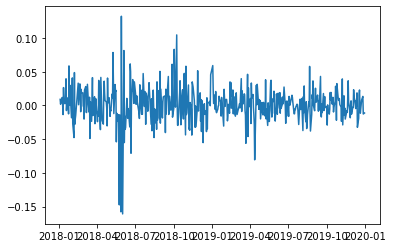

In [138]:
# Diferenciando a série para torná-la estacionária
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

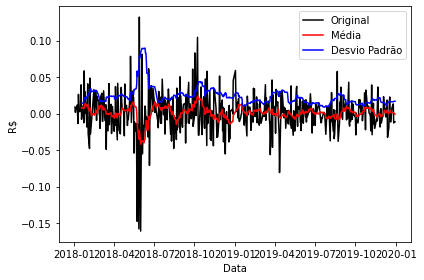

Results of Dickey-Fuller Test:
Test Statistic                -7.882451e+00
p-value                        4.663625e-12
#Lags Used                     5.000000e+00
Number of Observations Used    4.850000e+02
Critical Value (1%)           -3.443905e+00
Critical Value (5%)           -2.867518e+00
Critical Value (10%)          -2.569954e+00
dtype: float64


In [147]:
# Teste de ADF para a série em primeira diferença
teste_estacionariedade(ts_log_diff)
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(ts_log_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

O resultado do ADF para a variável em primeira diferença indica que ela é estacionária de ordem 1. I(1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


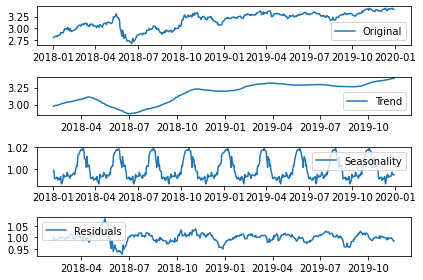

In [151]:
# Decomposição sazonal
decomposition = seasonal_decompose(ts_log, model='multiplicative', filt=None, freq=52) 
trend = decomposition.trend 
seasonal = decomposition.seasonal 
residual = decomposition.resid 
plt.subplot(411) 
plt.plot(ts_log, label='Original') 
plt.legend(loc='best') 
plt.subplot(412) 
plt.plot(trend, label='Trend') 
plt.legend(loc='best') 
plt.subplot(413) 
plt.plot(seasonal,label='Seasonality') 
plt.legend(loc='best') 
plt.subplot(414) 
plt.plot(residual, label='Residuals')
plt.legend(loc='best') 
plt.tight_layout()

Agora podemos modelar os resíduos separadamente, mas antes é necessário verificar a estacionariedade dos resíduos

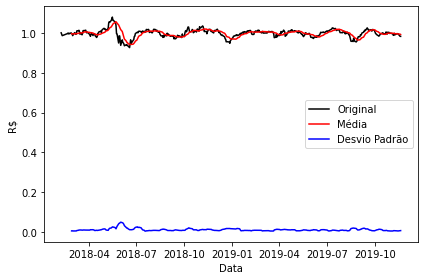

Results of Dickey-Fuller Test:
Test Statistic                -6.379565e+00
p-value                        2.239728e-08
#Lags Used                     1.500000e+01
Number of Observations Used    4.240000e+02
Critical Value (1%)           -3.445867e+00
Critical Value (5%)           -2.868381e+00
Critical Value (10%)          -2.570414e+00
dtype: float64


In [155]:
ts_log_decompose = residual 
ts_log_decompose.dropna(inplace=True) 
teste_estacionariedade(ts_log_decompose)

print ('Results of Dickey-Fuller Test:')
dftest = adfuller(ts_log_decompose, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Depois de verificar que os resíduos são estacionários, podemos partir para o modelo de previsão ARIMA. O Modelo Arima é uma técnica estatística muito utilizada na previsão de séries temporais. ARIMA quer dizer: modelo autorregressivo integrado de médias móveis. O AR é o componente autorregressivo da série, o I é o termo de diferenciação da variável no modelo e o MA é a ordem da média móvel. Os parâmetros que indicam a ordem do modelo ARIMA são conhecidos como p, q e d. O p são os lags do modelo (componente autorregressivo), o q é a ordem da média móvel e o d é a ordem de diferenciação.

Os passos anteriores de verificação de raiz unitária pelo teste de ADF, a função de ACF e PACF determinam as ordens do modelo ARIMA, justamente por isso é importante essa investigação antes de estimar e prever valores.


In [181]:
# ACF e PACF
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


Text(0.5, 1.0, 'Autocorrelation Function')

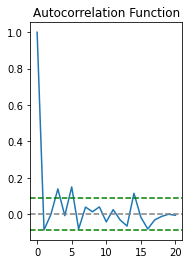

In [182]:
# Plotando o ACF
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='green')
plt.title('Autocorrelation Function')

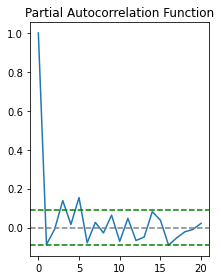

In [183]:
#Plot PACF: 
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(ts_log)),linestyle='--',color='green') 
plt.title('Partial Autocorrelation Function') 
plt.tight_layout()

O p indicado pela autocorrelação parcial é 2, já a autocorrelação indicada é 3. Nosso modeo ARIMA fica: (2,1,3)

In [192]:
# Vamos verificar com a função autoarima
!pip install pmdarima
from pmdarima.arima import auto_arima
#Identificando o modelo ARIMA 
model = auto_arima(ts_log, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(ts_log)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2159.165, Time=1.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2155.673, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2157.421, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2157.372, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2156.652, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2160.118, Time=0.85 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2155.628, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2155.431, Time=0.38 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-2169.550, Time=1.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-2165.956, Time=0.53 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-2173.720, Time=1.17 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-2171.272, Time=1.22 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-2171.378, Time=1.09 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-2169.734, Time=1.11 sec
 ARIMA(3,1,2)(0,0,0

ARIMA(order=(2, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 0.3336')

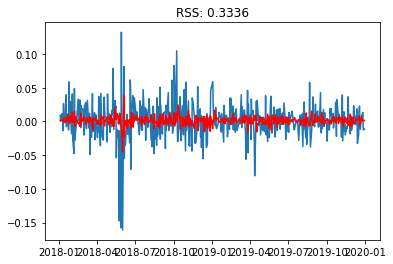

In [198]:
# Modelo ARIMA
model = ARIMA(ts_log, order=(2, 1, 3)) 
results_ARIMA = model.fit(disp=-1) 
plt.plot(ts_log_diff) 
plt.plot(results_ARIMA.fittedvalues, color='red') 
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))


In [200]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True) 
predictions_ARIMA_diff.head()

Date
2018-01-03    0.001230
2018-01-04    0.000575
2018-01-05    0.000975
2018-01-08    0.002173
2018-01-09    0.000463
dtype: float64

In [222]:
predictions_ARIMA_log = pd.Series(ts_log, index=ts_log.index)
predictions_ARIMA_log=predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0) 
predictions_ARIMA_log.head()

Date
2018-01-02    2.806386
2018-01-03    2.816639
2018-01-04    2.819009
2018-01-05    2.825944
2018-01-08    2.839930
dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


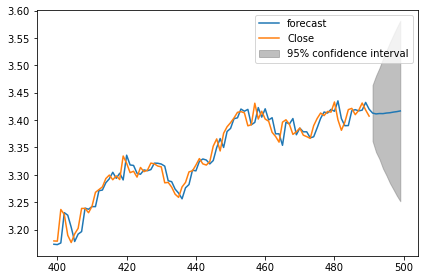

In [230]:

predict = results_ARIMA.plot_predict(start=400,end=500,dynamic=False) 
plt.tight_layout()
plt.show()

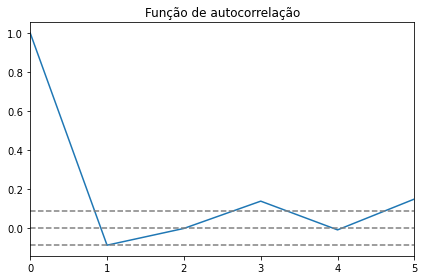

In [120]:
plt.plot(atraso_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(petr4_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(petr4_diff)),linestyle='--',color='gray')
plt.title('Função de autocorrelação')
plt.xlim([0,5])
plt.tight_layout()
plt.show()

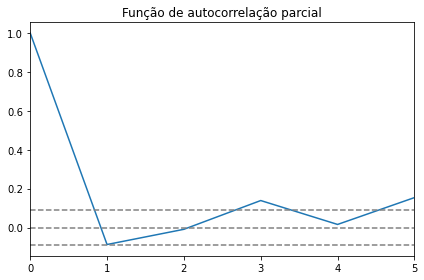

In [121]:
plt.plot(atraso_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(petr4_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(petr4_diff)),linestyle='--',color='gray')
plt.title('Função de autocorrelação parcial')
plt.xlim([0,5])
plt.tight_layout()
plt.show()

In [57]:
modelo = ARIMA(np.log(petr4_close), order=(1, 0, 1), freq=petr4_close.index.inferred_freq)
modelo_fit = modelo.fit(disp=-1)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
